In [36]:
import warnings
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import timeit

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

np.random.seed(123)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

c:\programdata\anaconda3\envs\hyperion\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [37]:
def country_selection(country_name, loc_mobility=None, loc_covid=None):
    
    avaliable_countries = ["Germany", "Japan", "Australia", "Canada",
                          "United States", "South Korea", "Italy", "Argentina",
                          "Turkey", "Thailand", "Algeria", "Mexico",
                          "India", "South Africa", "Bolivia", "Egypt"]
    
    if country_name not in avaliable_countries:
        warnings.warn("The selected country might not have optimal COVID data.")
    else:
        if country_name in ["Germany", "Japan", "Australia", "Canada"]:
            print("{0} is a Tier 1 country in IHDI".format(country_name))
        elif country_name in ["United States", "South Korea", "Italy", "Argentina"]:
            print("{0} is a Tier 2 country in IHDI".format(country_name))
        elif country_name in ["Turkey", "Thailand", "Algeria", "Mexico"]:
            print("{0} is a Tier 3 country in IHDI".format(country_name))
        else:
            print("{0} is a Tier 4 country in IHDI".format(country_name))
            
    if loc_mobility==None:
        loc_mobility="./Data/Google/Global_Mobility_Report.csv"
        
    mobility_data = pd.read_csv(loc_mobility, 
                                encoding="ISO-8859-1", 
                                parse_dates=["date"],
                                dayfirst=True)
    
    mobility_data = mobility_data[
        (mobility_data["country_region"]==country_name) & (mobility_data["sub_region_1"].isnull())]
    mobility_data = mobility_data.iloc[:,7:].reset_index(drop=True) # keep only relevant columns
    mobility_data.iloc[:,1:] = mobility_data.iloc[:,1:].apply(lambda x: x/100 + 1)
    
    mobility_data = pd.DataFrame({
        "date": mobility_data["date"],
        "HOME": mobility_data['residential_percent_change_from_baseline'],
        "WORK": mobility_data['workplaces_percent_change_from_baseline'],
        "OTHER": mobility_data.iloc[:,1:5].mean(axis=1)
        })
    mobility_data.reset_index(drop=True, inplace=True)
    
    if loc_covid==None:
        loc_covid="./Data/Microsoft/COVID_CASES.csv"
     # COVID Cases from Microsoft, includes Recovered and Infected
    ms_covid = pd.read_csv(loc_covid, 
                           encoding="ISO-8859-1",
                           parse_dates=["Updated"],
                           dayfirst=False)
    
    ms_covid = ms_covid[(ms_covid["Country_Region"]==country_name) & (ms_covid["AdminRegion1"].isnull())]
    ms_covid = ms_covid.loc[:,["Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]   
    
    # Create the 3 categories S, I, R for US data (UK does not include R)
    ms_covid = ms_covid.fillna(method='ffill').fillna(0)

    # DIFF: Instead of smoothing the I, Daily cases and S, ammend the problematic R value @ 2020-07-18
    # To match the next 2020-07-19
    if country_name=="United States":
        ms_covid.iloc[178, 4] = 1117084.0
        
    # Read the countries population from World Bank Database 2019
    pop_dt = pd.read_excel(
        "./Data/Population/Data_Extract_From_World_Development_Indicators.xlsx")
    

    population_size = pop_dt.loc[pop_dt.CountryName==country_name, "Total"].values[0]
    
    ms_covid["I"] = ms_covid["Confirmed"] - ms_covid["Deaths"] - ms_covid["Recovered"]
    ms_covid["S"] = population_size - ms_covid["I"]
    ms_covid["index"] = ms_covid["Updated"].dt.dayofyear

    # DIFF: Create a time variable
    # If we have a weekend then assign 0 or weekday 1
    ms_covid["WEEKDAY"] = 0
    ms_covid.loc[ms_covid.Updated.dt.dayofweek < 5, "WEEKDAY"] = 1
    ms_covid.dropna(inplace=True)
    ms_covid.reset_index(drop=True, inplace=True)
    
    final_data = ms_covid.set_index("Updated").merge(
    mobility_data.set_index("date"), how='left', left_index=True, right_index=True).reset_index()
    final_data.dropna(inplace=True)
    final_data.reset_index(drop=True, inplace=True)
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 4))
    final_data.set_index("Updated")[["ConfirmedChange"]].plot(ax=axs[0, 0])
    final_data.set_index("Updated")[["I"]].plot(ax=axs[0, 1])
    final_data.set_index("Updated")[["S"]].plot(ax=axs[0, 2])
    final_data.set_index("Updated")[["HOME"]].plot(ax=axs[1, 0])
    final_data.set_index("Updated")[["WORK"]].plot(ax=axs[1, 1])
    final_data.set_index("Updated")[["OTHER"]].plot(ax=axs[1, 2])
    
    print(round(final_data.describe(), 3))
    
    return(final_data)

In [38]:
country_name = 'United States'

United States is a Tier 2 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


         Confirmed  ConfirmedChange      Deaths    Recovered            I  \
count  164.000      164.000          164.000     164.000      164.000       
mean   1347865.128  25773.750        61438.500   348933.384   937493.244    
std    1211412.229  19564.754        50044.371   391793.828   784056.706    
min    15.000       0.000            1.000       3.000        11.000        
25%    96250.500    16244.000        1486.750    2002.750     92761.000     
50%    1233799.500  24425.000        68714.500   172225.500   992859.500    
75%    2106308.000  32645.500        109566.500  675747.250   1334682.500   
max    4226910.000  75821.000        136917.000  1308646.000  2781347.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.640000e+02  164.000  164.000  164.000  164.000  164.000  
mean   2.416833e+08  127.500  0.707    1.105    0.702    0.922    
std    7.840567e+05  47.487   0.456    0.069    0.177    0.149    
min    2.398395e+08  46.000   0.000   

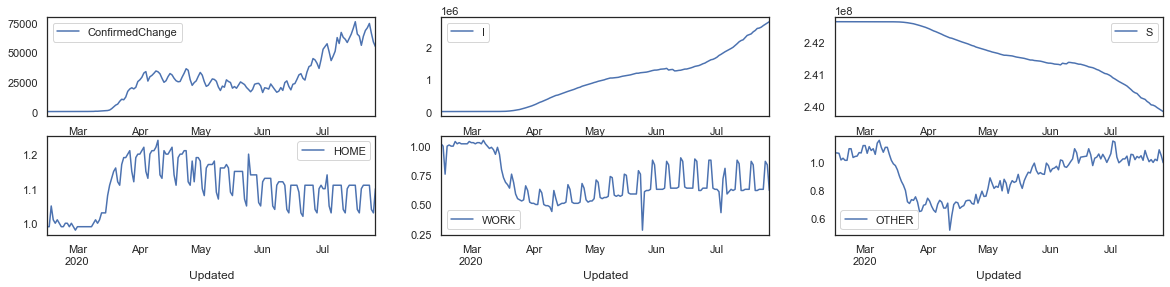

In [42]:
final_data = country_selection(country_name, loc_mobility=None, loc_covid=None)

In [46]:
from experiment import run_experiment, Report

In [44]:
def train_test_split_func(t, X, y):
    t_train, t_test = t[:-21,:], t[-21:,:]
    X_train, X_test = X[:-21,:], X[-21:,:]
    y_train, y_test = y[:-21,:], y[-21:,:]
    
    return t_train, t_test, X_train, X_test, y_train, y_test

### **$\lambda (t) = f(S(t)I(t), Home(t), Work(t), Other(t))$** - Gaussian - SE\*L\*RQ

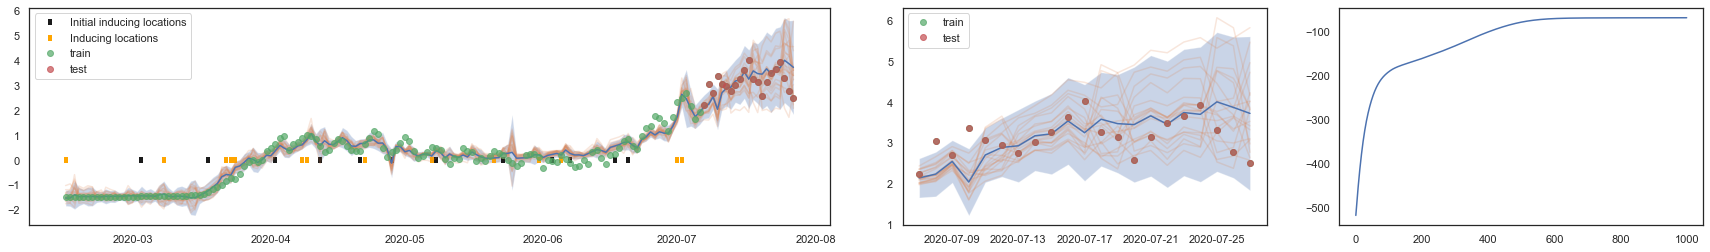

In [47]:
t = final_data[["Updated"]].to_numpy()
y = final_data[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (final_data["S"] * final_data["I"]).to_numpy().reshape(-1, 1),
    final_data[["WEEKDAY"]].to_numpy(),
    final_data[["HOME"]].to_numpy(),
    final_data[["WORK"]].to_numpy(),
    final_data[["OTHER"]].to_numpy(),
])

model_params = {
    'kernel': (
        gpflow.kernels.SquaredExponential() *
        gpflow.kernels.Linear() *
        gpflow.kernels.RationalQuadratic()
    ),
    'n_inducing': (15)
}

res, model = run_experiment('$f(S(t)I(t), WKDAY(t), Home(t), Work(t), Other(t)$', 
                            t, X, y, model_params=model_params, train_test_split_func=train_test_split_func, plot=True)

In [48]:
res.to_pandas()

,Summary
Model,"$f(S(t)I(t), WKDAY(t), Home(t), Work(t), Other(t)$"
Likelihood,Gaussian
Kernel,Product
ELBO,-69.33
Training-set dates,2020-02-15 to 2020-07-06
Test-set dates,2020-07-07 to 2020-07-27
train_size,143
test_size,21
Number of inducing points,15
run_time,105.01


# Germany

Germany is a Tier 1 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


        Confirmed  ConfirmedChange    Deaths   Recovered          I  \
count  164.000     164.000          164.000   164.000     164.000     
mean   125546.720  1253.616         5207.518  102180.280  18158.921   
std    77468.168   1590.972         3831.982  76601.534   21100.108   
min    16.000      0.000            0.000     1.000       2.000       
25%    40843.000   314.750          239.250   4057.000    5204.750    
50%    165449.000  546.000          7057.500  134146.000  6654.500    
75%    186925.250  1347.500         8807.500  173070.000  27348.250   
max    205609.000  6294.000         9118.000  190350.000  72959.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.640000e+02  164.000  164.000  164.000  164.000  164.000  
mean   7.164274e+07  127.500  0.707    1.075    0.779    0.997    
std    2.110011e+04  47.487   0.456    0.061    0.193    0.199    
min    7.158794e+07  46.000   0.000    0.970    0.120    0.387    
25%    7.163355e+07  86.7

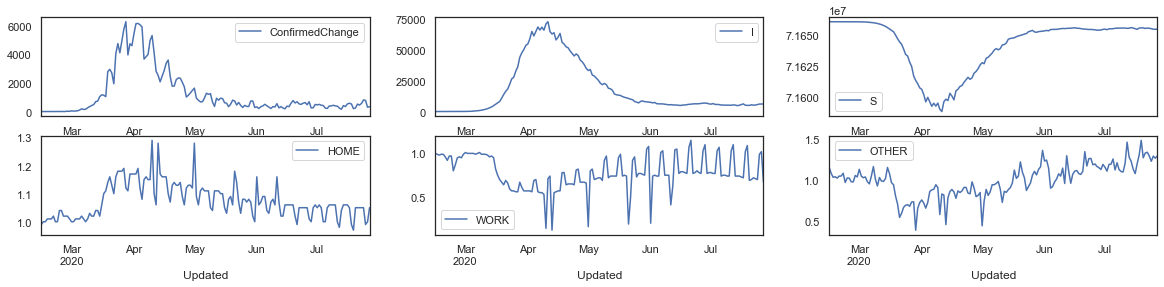

In [58]:
country_dt = country_selection("Germany", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

In [61]:
mean, var = model.predict(X_norm)
#y_train_pred = X_scaler.inverse_transform(mean.numpy())

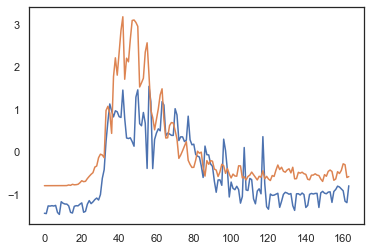

In [62]:
plt.plot(mean)
plt.plot(y_norm)

# Japan

Japan is a Tier 1 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


       Confirmed  ConfirmedChange   Deaths  Recovered          I  \
count  164.000    164.000          164.000  164.000    164.000     
mean   11814.518  182.610          506.994  8059.488   3248.037    
std    8502.202   204.239          413.667  7669.928   3314.812    
min    53.000     6.000            1.000    12.000     40.000      
25%    1471.000   37.500           48.250   359.000    803.000     
50%    15505.000  85.000           554.000  4918.000   1630.000    
75%    17597.250  279.000          928.000  15738.250  4808.000    
max    29989.000  927.000          996.000  22116.000  10620.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.640000e+02  164.000  164.000  164.000  164.000  164.000  
mean   1.103864e+08  127.500  0.707    1.083    0.847    0.878    
std    3.314812e+03  47.487   0.456    0.053    0.138    0.098    
min    1.103790e+08  46.000   0.000    1.000    0.270    0.578    
25%    1.103848e+08  86.750   0.000    1.050    0.79

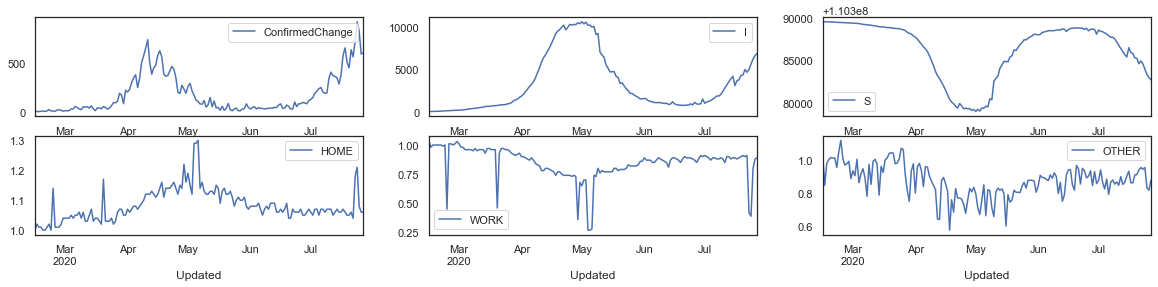

In [63]:
country_dt = country_selection("Japan", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

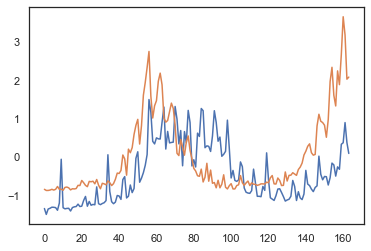

In [64]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Australia

Australia is a Tier 1 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


       Confirmed  ConfirmedChange   Deaths  Recovered         I             S  \
count  164.000    164.000          164.000  164.000    164.000   1.640000e+02   
mean   5805.305   90.976           69.268   4396.616   1339.421  2.047388e+07   
std    3620.088   128.248          45.735   3148.440   1403.412  1.403412e+03   
min    15.000     0.000            0.000    10.000     5.000     2.046976e+07   
25%    3085.500   10.000           13.000   118.000    433.750   2.047293e+07   
50%    6885.500   21.000           97.000   6004.500   668.500   2.047455e+07   
75%    7352.750   117.500          103.000  6856.500   2293.750  2.047479e+07   
max    14935.000  532.000          161.000  9311.000   5463.000  2.047522e+07   

         index  WEEKDAY     HOME     WORK    OTHER  
count  164.000  164.000  164.000  164.000  164.000  
mean   127.500  0.707    1.099    0.819    0.808    
std    47.487   0.456    0.066    0.176    0.140    
min    46.000   0.000    0.970    0.180    0.372    
25%  

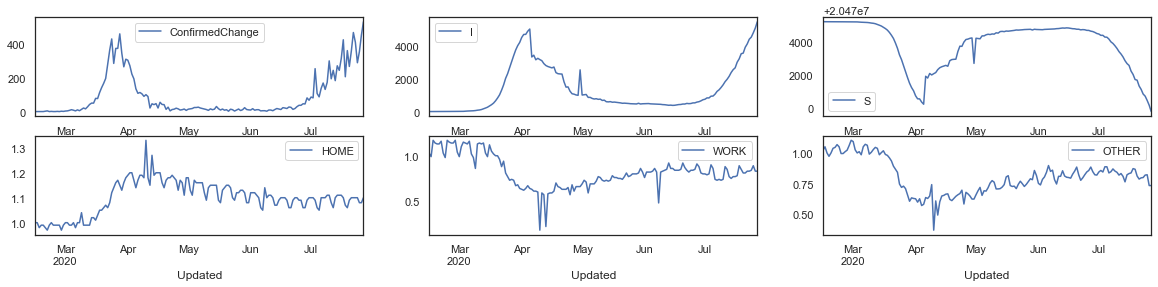

In [65]:
country_dt = country_selection("Australia", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

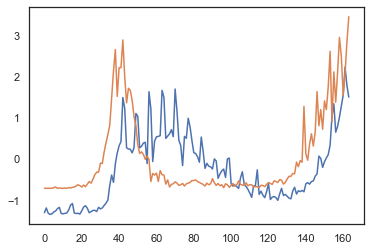

In [66]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Canada

Canada is a Tier 1 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


        Confirmed  ConfirmedChange    Deaths  Recovered          I  \
count  164.000     164.000          164.000   164.000    164.000     
mean   56124.921   698.713          4217.079  32946.524  18961.317   
std    43550.052   581.283          3681.647  31191.456  13509.228   
min    8.000       0.000            0.000     1.000      3.000       
25%    4578.500    221.250          51.000    242.000    4125.000    
50%    64209.000   544.000          4320.000  28709.000  27161.000   
75%    99563.500   1156.250         8223.250  61554.250  30928.250   
max    114597.000  2760.000         8901.000  99860.000  36738.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.640000e+02  164.000  164.000  164.000  164.000  164.000  
mean   3.161394e+07  127.500  0.707    1.124    0.655    0.950    
std    1.350923e+04  47.487   0.456    0.082    0.223    0.241    
min    3.159617e+07  46.000   0.000    0.980    0.190    0.465    
25%    3.160198e+07  86.750   0.00

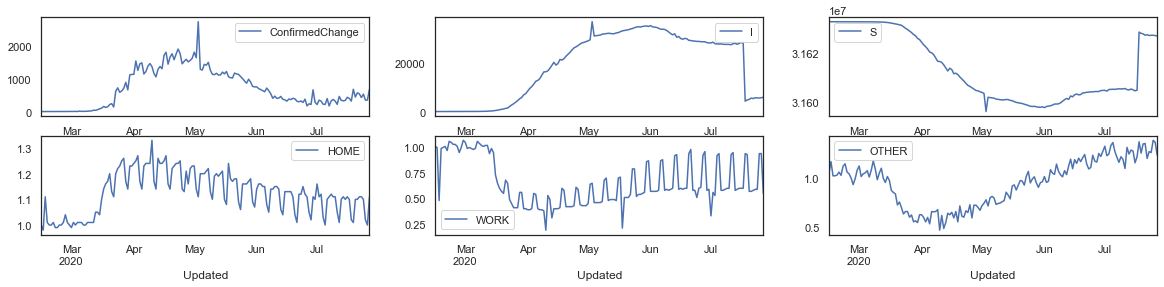

In [67]:
country_dt = country_selection("Canada", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

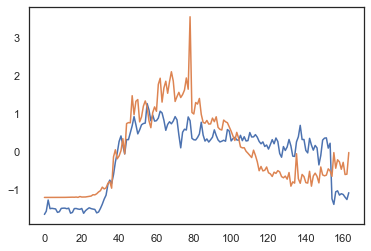

In [68]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# South Korea

South Korea is a Tier 2 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


KeyError: "None of ['Updated'] are in the columns"

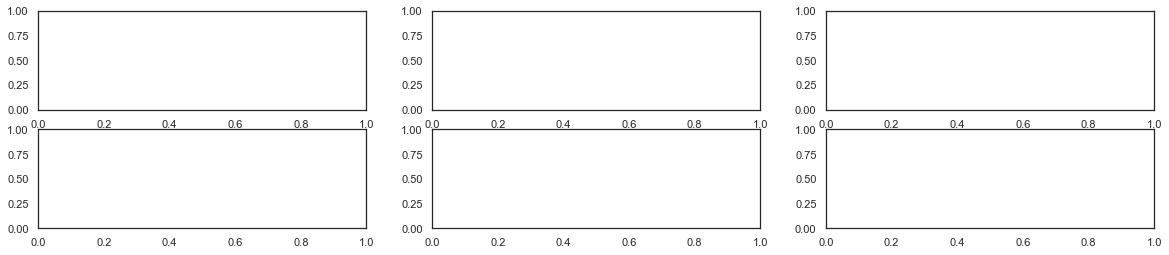

In [84]:
country_dt = country_selection("South Korea", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

In [ ]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Italy

Italy is a Tier 2 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


        Confirmed  ConfirmedChange     Deaths   Recovered           I  \
count  164.000     164.000          164.000    164.000     164.000      
mean   163080.866  1501.726         22608.268  84407.323   56065.274    
std    92281.668   1751.607         13675.309  74291.716   47217.757    
min    3.000       0.000            0.000      0.000       3.000        
25%    85008.250   220.250          8904.250   10361.000   13327.000    
50%    215157.500  580.500          29821.000  64024.000   46407.000    
75%    237582.000  2647.250         34415.750  161177.250  96985.750    
max    246286.000  6557.000         35112.000  198593.000  167161.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.640000e+02  164.000  164.000  164.000  164.000  164.000  
mean   5.230218e+07  127.500  0.707    1.137    0.645    0.702    
std    4.721776e+04  47.487   0.456    0.123    0.235    0.335    
min    5.219108e+07  46.000   0.000    0.930    0.100    0.078    
25%    

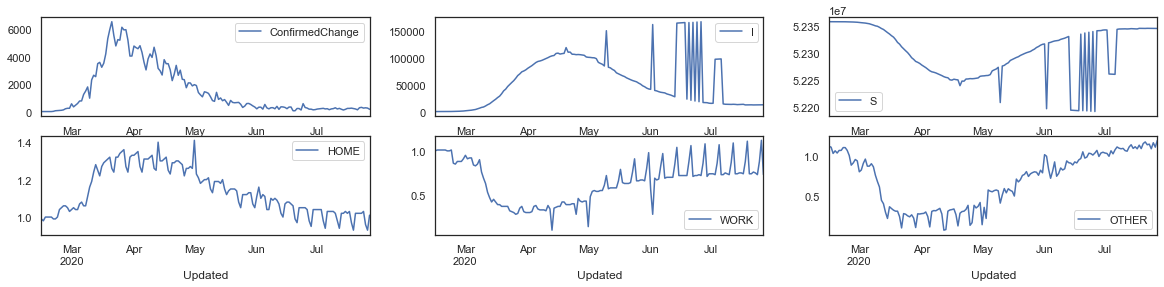

In [73]:
country_dt = country_selection("Italy", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

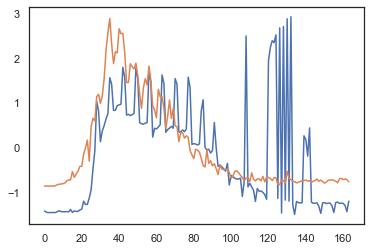

In [74]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Argentina

Argentina is a Tier 2 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


        Confirmed  ConfirmedChange    Deaths  Recovered          I  \
count  147.000     147.000          147.000   147.000    147.000     
mean   30286.925   1138.789         665.592   11076.245  18545.088   
std    43135.049   1493.706         774.464   17723.813  24852.549   
min    1.000       0.000            0.000     0.000      1.000       
25%    1844.500    94.000           72.000    322.500    1457.000    
50%    7466.000    303.000          356.000   2372.000   4738.000    
75%    41981.500   2009.000         1001.500  12015.500  28964.500   
max    167403.000  6127.000         3059.000  70505.000  93839.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.470000e+02  147.000  147.000  147.000  147.000  147.000  
mean   3.386725e+07  136.000  0.714    1.191    0.668    0.448    
std    2.485255e+04  42.579   0.453    0.076    0.213    0.193    
min    3.379196e+07  63.000   0.000    0.980    0.210    0.168    
25%    3.385683e+07  99.500   0.00

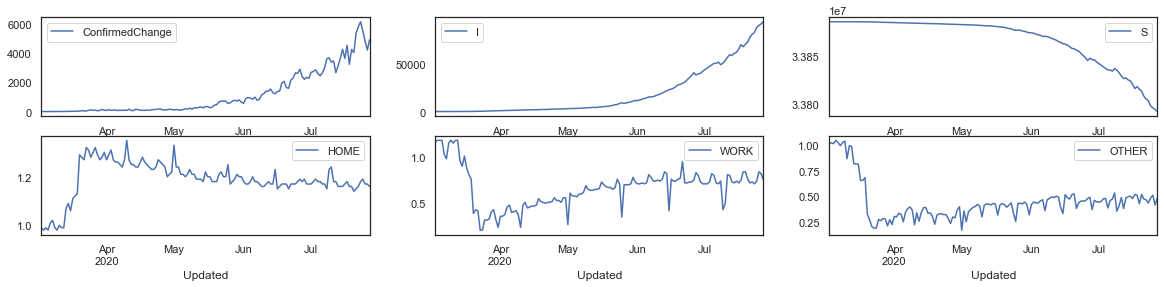

In [77]:
country_dt = country_selection("Argentina", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

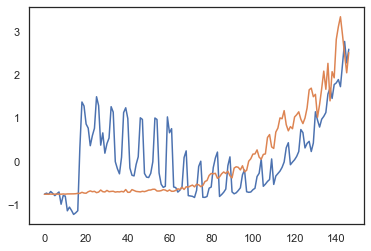

In [78]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Turkey

Turkey is a Tier 3 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


        Confirmed  ConfirmedChange    Deaths   Recovered          I  \
count  140.000     140.000          140.000   140.000     140.000     
mean   127887.764  1621.557         3329.136  95180.121   29378.507   
std    75265.786   1188.588         1991.500  75645.234   21607.645   
min    1.000       0.000            0.000     0.000       1.000       
25%    64095.500   936.000          1376.250  4588.500    13744.250   
50%    151104.000  1193.500         4185.000  112236.000  23819.500   
75%    189214.000  1978.500         4980.750  161861.750  36895.750   
max    227019.000  5138.000         5630.000  210469.000  80808.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.400000e+02  140.000  140.000  140.000  140.000  140.000  
mean   6.313450e+07  139.500  0.714    1.120    0.679    0.756    
std    2.160765e+04  40.559   0.453    0.109    0.222    0.310    
min    6.308307e+07  70.000   0.000    0.960    0.150    0.132    
25%    6.312698e+07  104.

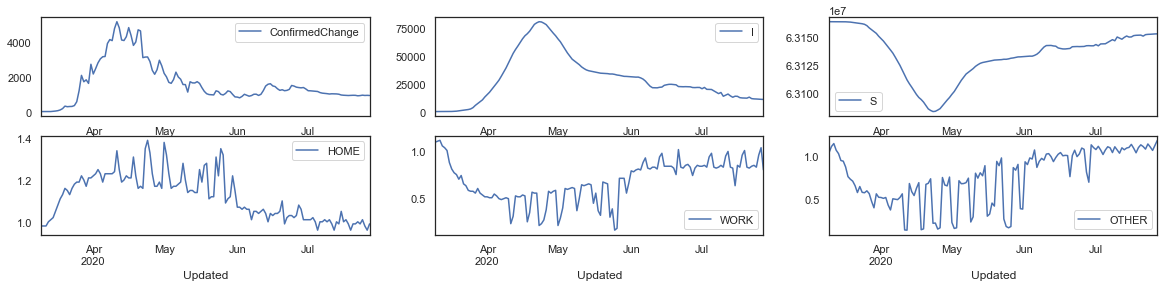

In [79]:
country_dt = country_selection("Turkey", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

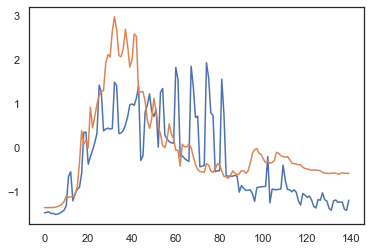

In [80]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Thailand

Thailand is a Tier 3 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


       Confirmed  ConfirmedChange   Deaths  Recovered         I             S  \
count  164.000    164.000          164.000  164.000    164.000   1.640000e+02   
mean   2231.726   19.890           38.329   1899.665   293.732   5.791180e+07   
std    1257.868   35.642           24.610   1313.198   434.718   4.347180e+02   
min    34.000     0.000            0.000    13.000     12.000    5.791056e+07   
25%    1113.250   1.000            4.750    94.750     59.750    5.791187e+07   
50%    2990.500   4.500            55.000   2761.000   86.000    5.791201e+07   
75%    3137.500   15.500           58.000   2993.750   228.250   5.791204e+07   
max    3295.000   188.000          58.000   3111.000   1534.000  5.791208e+07   

         index  WEEKDAY     HOME     WORK    OTHER  
count  164.000  164.000  164.000  164.000  164.000  
mean   127.500  0.707    1.098    0.825    0.783    
std    47.487   0.456    0.057    0.124    0.145    
min    46.000   0.000    1.010    0.450    0.500    
25%  

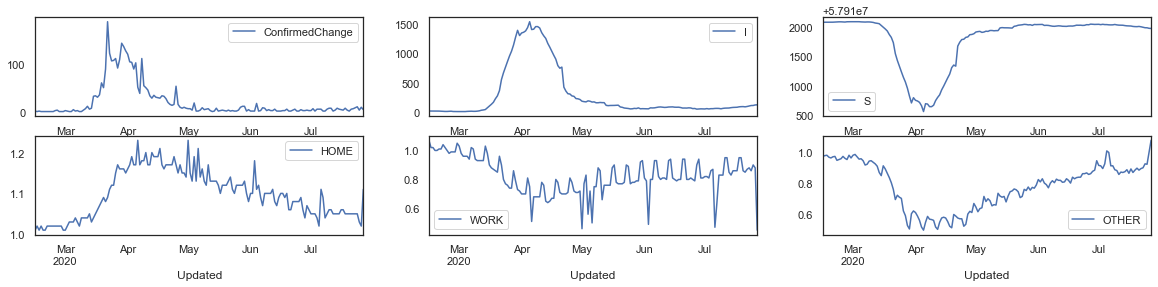

In [81]:
country_dt = country_selection("Thailand", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

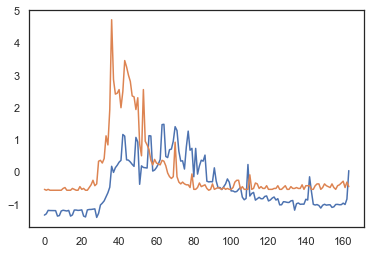

In [82]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Algeria

Algeria is a Tier 3 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


       Confirmed  ConfirmedChange  Deaths  Recovered    I    S  index  \
count  0.0        0.0              0.0     0.0        0.0  0.0  0.0     
mean  NaN        NaN              NaN     NaN        NaN  NaN  NaN      
std   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
min   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
25%   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
50%   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
75%   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
max   NaN        NaN              NaN     NaN        NaN  NaN  NaN      

       WEEKDAY  HOME  WORK  OTHER  
count  0.0      0.0   0.0   0.0    
mean  NaN      NaN   NaN   NaN     
std   NaN      NaN   NaN   NaN     
min   NaN      NaN   NaN   NaN     
25%   NaN      NaN   NaN   NaN     
50%   NaN      NaN   NaN   NaN     
75%   NaN      NaN   NaN   NaN     
max   NaN      NaN   NaN   NaN     


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

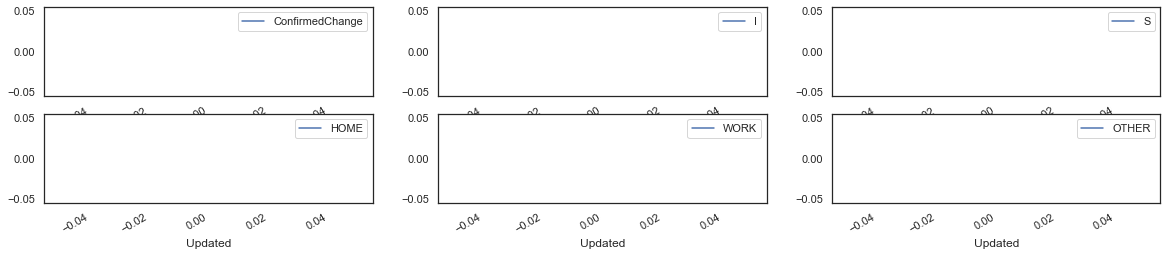

In [83]:
country_dt = country_selection("Algeria", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

In [ ]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Mexico

Mexico is a Tier 3 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


        Confirmed  ConfirmedChange     Deaths   Recovered          I  \
count  151.000     151.000          151.000    151.000     151.000     
mean   98981.530   2619.113         11450.364  62145.589   25385.576   
std    118635.905  2427.671         13891.640  74437.605   31414.789   
min    3.000       0.000            0.000      0.000       3.000       
25%    2291.000    256.500          109.500    633.000     1636.500    
50%    40186.000   1997.000         4220.000   17781.000   13179.000   
75%    172843.500  4684.000         20587.500  119958.500  27015.000   
max    395489.000  8438.000         44022.000  251505.000  99962.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.510000e+02  151.000  151.000  151.000  151.000  151.000  
mean   9.414434e+07  134.000  0.709    1.148    0.701    0.654    
std    3.141479e+04  43.734   0.456    0.071    0.189    0.155    
min    9.406976e+07  59.000   0.000    0.980    0.280    0.425    
25%    9.414271e

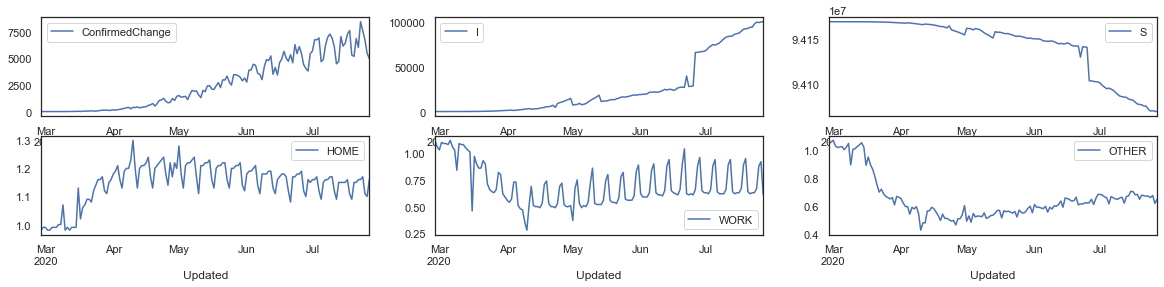

In [85]:
country_dt = country_selection("Mexico", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

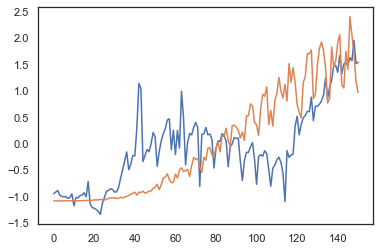

In [86]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# India

India is a Tier 4 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


         Confirmed  ConfirmedChange     Deaths   Recovered           I  \
count  164.000      164.000          164.000    164.000     164.000      
mean   240385.957   8752.744         6574.890   139047.226  94763.841    
std    356544.221   12156.299        9106.277   225674.864  123077.314   
min    3.000        0.000            0.000      0.000       0.000        
25%    799.000      102.500          18.250     38.750      719.250      
50%    51171.500    3298.500         1738.500   14725.000   34708.000    
75%    345834.500   11608.750        10400.750  181743.500  153690.250   
max    1435453.000  49931.000        32771.000  917568.000  485114.000   

                  S    index  WEEKDAY     HOME     WORK    OTHER  
count  1.640000e+02  164.000  164.000  164.000  164.000  164.000  
mean   1.002606e+09  127.500  0.707    1.166    0.654    0.602    
std    1.230773e+05  47.487   0.456    0.097    0.227    0.229    
min    1.002216e+09  46.000   0.000    0.990    0.280    0.295   

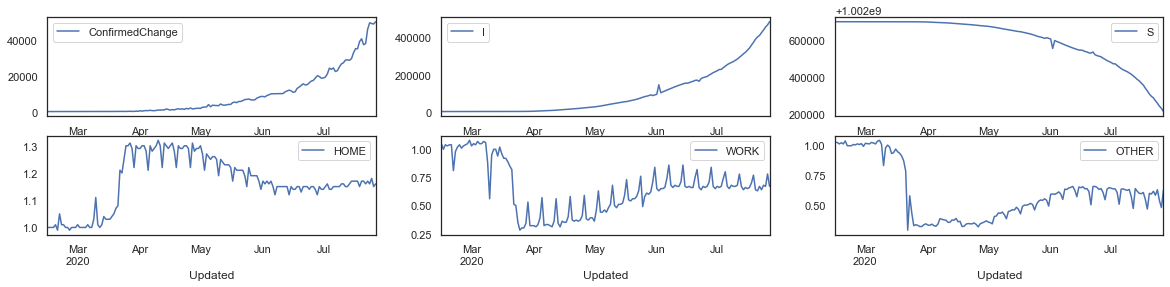

In [87]:
country_dt = country_selection("India", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

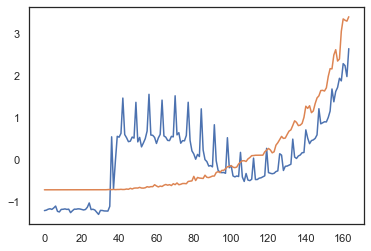

In [88]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# South Africa

South Africa is a Tier 4 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


       Confirmed  ConfirmedChange  Deaths  Recovered    I    S  index  \
count  0.0        0.0              0.0     0.0        0.0  0.0  0.0     
mean  NaN        NaN              NaN     NaN        NaN  NaN  NaN      
std   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
min   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
25%   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
50%   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
75%   NaN        NaN              NaN     NaN        NaN  NaN  NaN      
max   NaN        NaN              NaN     NaN        NaN  NaN  NaN      

       WEEKDAY  HOME  WORK  OTHER  
count  0.0      0.0   0.0   0.0    
mean  NaN      NaN   NaN   NaN     
std   NaN      NaN   NaN   NaN     
min   NaN      NaN   NaN   NaN     
25%   NaN      NaN   NaN   NaN     
50%   NaN      NaN   NaN   NaN     
75%   NaN      NaN   NaN   NaN     
max   NaN      NaN   NaN   NaN     


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by StandardScaler.

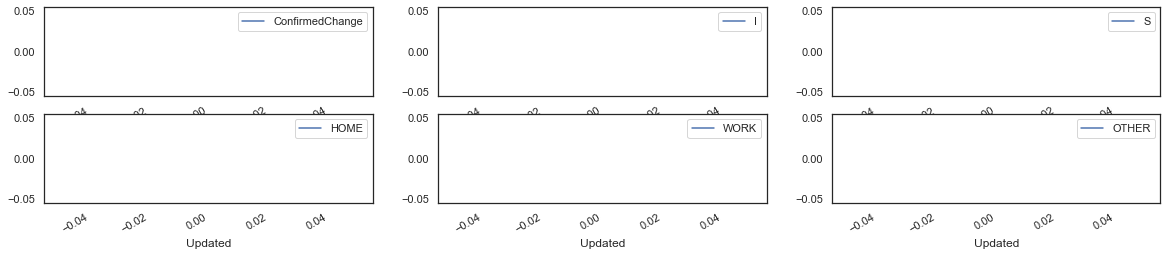

In [89]:
country_dt = country_selection("South Africa", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

In [ ]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Bolivia

Bolivia is a Tier 4 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


       Confirmed  ConfirmedChange    Deaths  Recovered          I  \
count  140.000    140.000          140.000   140.000    140.000     
mean   15473.321  507.493          557.114   3868.779   11047.429   
std    20330.528  567.164          738.063   6130.766   13584.135   
min    139.000    0.000            10.000    0.000      129.000     
25%    386.250    26.500           28.000    5.000      353.250     
50%    4372.000   255.500          181.500   498.000    3692.500    
75%    25717.000  934.250          826.500   5278.750   20386.500   
max    71181.000  2036.000         2647.000  21169.000  47365.000   

                 S    index  WEEKDAY     HOME     WORK    OTHER  
count  140.000      140.000  140.000  140.000  140.000  140.000  
mean   7976135.571  139.457  0.714    1.301    0.454    0.356    
std    13584.135    40.636   0.453    0.088    0.210    0.208    
min    7939818.000  64.000   0.000    0.980    0.130    0.073    
25%    7966796.500  104.750  0.000    1.260    0

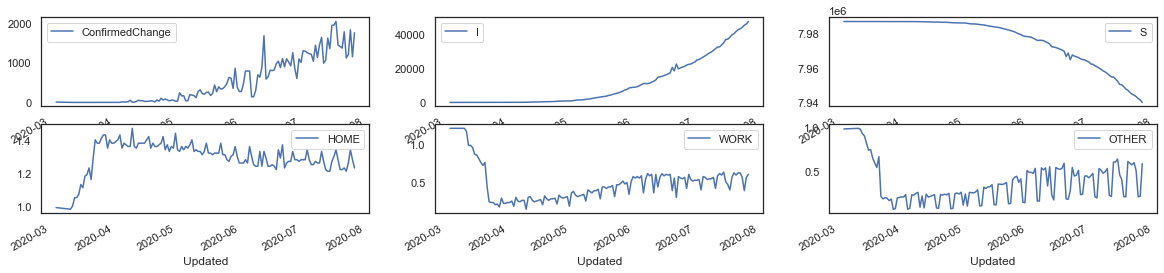

In [90]:
country_dt = country_selection("Bolivia", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

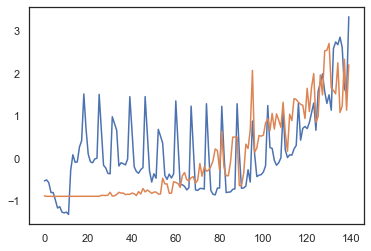

In [91]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)

# Egypt

Egypt is a Tier 4 country in IHDI


c:\programdata\anaconda3\envs\hyperion\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


KeyError: "None of ['Updated'] are in the columns"

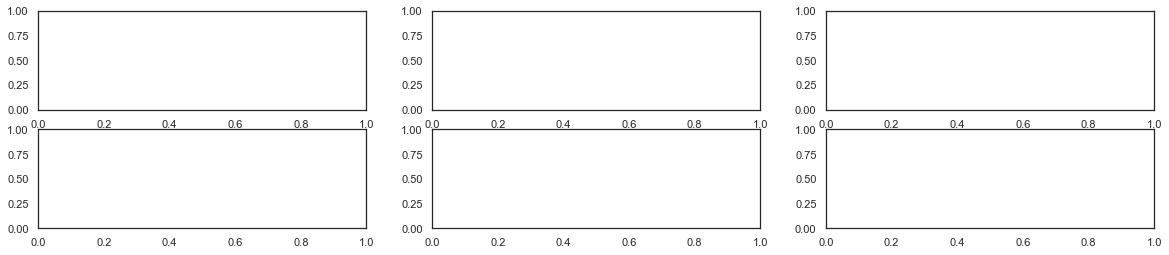

In [92]:
country_dt = country_selection("Egypt", loc_mobility=None, loc_covid=None)
y = country_dt[["ConfirmedChange"]].to_numpy()
X = np.hstack([
    (country_dt["S"] * country_dt["I"]).to_numpy().reshape(-1, 1),
    country_dt[["WEEKDAY"]].to_numpy(),
    country_dt[["HOME"]].to_numpy(),
    country_dt[["WORK"]].to_numpy(),
    country_dt[["OTHER"]].to_numpy(),
])

X_scaler = preprocessing.StandardScaler().fit(X)
X_norm = X_scaler.transform(X)

y_scaler = preprocessing.StandardScaler().fit(y)
y_norm = y_scaler.transform(y)

In [ ]:
mean, var = model.predict(X_norm)
plt.plot(mean)
plt.plot(y_norm)